In [18]:
# utilities
import re
import pickle
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# nltk
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import plot_roc_curve


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score,StratifiedShuffleSplit

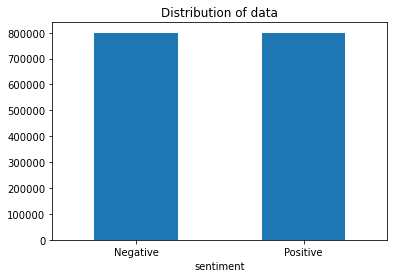

In [19]:
# Importing the dataset
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('/Users/connormcdonald/Desktop/Masters/MIT807/Data/training.csv',
                      encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

# Removing the unnecessary columns.
dataset = dataset[['sentiment','text']]
# Replacing the values to ease understanding.
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

# Plotting the distribution for dataset.
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

# Storing data in lists.
text, sentiment = list(dataset['text']), list(dataset['sentiment'])

In [20]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}
          
## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [21]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText


In [22]:
import time
t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 87 seconds


In [23]:
X_train, X_test1, y_train, y_test1 = train_test_split(processedtext, sentiment,
                                                    test_size = 0.01, random_state = 2022)
print(f'Data Split done.')

Data Split done.


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_test1, y_test1,
                                                    test_size = 0.20, random_state = 2022)
print(f'Data Split done.')

Data Split done.


In [25]:
#total features = 242 041 for uni grams

#total features = 12 180 564 for uni, bi and trigrams

#total features = 11 938 523 for bi and trigrams


uni, unirange = 242041, (1,1)
unibi, unibirange = 3443736, (1,2)
bi, birange = 3201695, (2,2)
unibitri, unibitrirange = 12180564,(1,3)
bitri, bitrirange = 11938523, (2,3)
tri, trirange = 8736828, (3,3)



def create_vectoriser(ngram, nrange):

    top20perc = int(0.2*ngram)
    vectoriser = TfidfVectorizer(ngram_range=nrange, max_features=top20perc) 
    vectoriser.fit(X_train)
    print(f'Vectoriser fitted.')
    print('No. of feature_words: ', len(vectoriser.get_feature_names()))
    return vectoriser


vectoriser = create_vectoriser(unibi, unibirange)

Vectoriser fitted.
No. of feature_words:  95936


In [26]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


In [27]:
from sklearn.model_selection import GridSearchCV

params = {'alpha': [0.01, 0.1, 0.5, 1.0, 2, 5],
          'fit_prior': [True, False],
          'class_prior': [None, [0.1,]* 2]
         }

multinomial_nb_grid = GridSearchCV(MultinomialNB(), param_grid=params, n_jobs=-1, cv=3, verbose=5)
multinomial_nb_grid.fit(X_train,y_train)

print('Best Accuracy Through Grid Search : {:.3f}'.format(multinomial_nb_grid.best_score_))
print('Best Parameters : {}\n'.format(multinomial_nb_grid.best_params_))

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Accuracy Through Grid Search : 0.755
Best Parameters : {'alpha': 2, 'class_prior': None, 'fit_prior': False}



In [28]:
MNB = pickle.load(open('/Users/connormcdonald/Desktop/Masters/MIT807/Gartner Repository/Classification/Code/saved_models/Sentiment-MNB.pickle', 'rb'))
LR = pickle.load(open('/Users/connormcdonald/Desktop/Masters/MIT807/Gartner Repository/Classification/Code/saved_models/Sentiment-LR.pickle', 'rb'))
SVM = pickle.load(open('/Users/connormcdonald/Desktop/Masters/MIT807/Gartner Repository/Classification/Code/saved_models/Sentiment-SVC.pickle', 'rb'))
vectorisor = pickle.load(open('/Users/connormcdonald/Desktop/Masters/MIT807/Gartner Repository/Classification/Code/saved_models/vectoriser-ngram-(1,2).pickle', 'rb'))

In [29]:
LR.get_params()

{'C': 2,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': -1,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [30]:
SVM.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': 1000,
 'probability': True,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [39]:
# defining parameter range
params = {'C': [0.1, 1, 5, 10],
            'gamma'  : [0.01, 0.1, 1, 10, 100],
            'kernel': ['linear', 'rbf']} 
  
svm_grid = GridSearchCV(SVC(),  param_grid=params, n_jobs=-1, verbose=5)
svm_grid.fit(X_train,y_train)

print('Best Accuracy Through Grid Search : {:.3f}'.format(svm_grid.best_score_))
print('Best Parameters : {}\n'.format(svm_grid.best_params_))

Fitting 5 folds for each of 40 candidates, totalling 200 fits


KeyboardInterrupt: 

In [40]:
params = [    
    {'penalty' : ['l1', 'l2'],
    'C' : [0.1, 1, 2, 5, 10],
    'solver' : ['lbfgs','liblinear'],
    'max_iter' : [10, 25,100, 1000]
    }
]

lr_grid = GridSearchCV(LogisticRegression(),  param_grid=params, n_jobs=-1, cv=2, verbose=5)
lr_grid.fit(X_train,y_train)

print('Best Accuracy Through Grid Search : {:.3f}'.format(lr_grid.best_score_))
print('Best Parameters : {}\n'.format(lr_grid.best_params_))

Fitting 2 folds for each of 80 candidates, totalling 160 fits


/Users/connormcdonald/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.5809375  0.71835938 0.71867188        nan 0.5809375
 0.71835938 0.71867188        nan 0.5809375  0.71835938 0.71867188
        nan 0.5809375  0.71835938 0.71867188        nan 0.72757812
 0.75179688 0.75203125        nan 0.72765625 0.75203125 0.75203125
        nan 0.72765625 0.75210938 0.75203125        nan 0.72765625
 0.75210938 0.75203125        nan 0.7453125  0.75578125 0.75523438
        nan 0.7453125  0.75515625 0.75523438        nan 0.7453125
 0.75523438 0.75523438        nan 0.7453125  0.75523438 0.75523438
        nan 0.74976562 0.75921875 0.75929687        nan 0.7496875
 0.75921875 0.75929687        nan 0.7496875  0.7590625  0.75929687
        nan 0.7496875  0.7590625  0.75929687        nan 0.7440625
 0.75960937 0.75929687        nan 0.74453125 0.759375   0.75929687
        nan 0.74453125 0.75929687 0.

Best Accuracy Through Grid Search : 0.760
Best Parameters : {'C': 10, 'max_iter': 10, 'penalty': 'l2', 'solver': 'lbfgs'}



/Users/connormcdonald/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [33]:
MNBmodel = MultinomialNB(alpha=2)
MNBmodel.fit(X_train, y_train)
# model_Evaluate(MNBmodel)


cv = StratifiedShuffleSplit(n_splits=10, test_size=0.05, random_state=0)
accuracies = cross_val_score(estimator = MNBmodel, X = X_train, y = y_train, cv = cv)
print(f"Accuracy per fold: {accuracies}")
print("Mean Fold Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy per fold: [0.7609375 0.759375  0.75625   0.7515625 0.765625  0.7609375 0.75625
 0.75625   0.734375  0.7734375]
Mean Fold Accuracy: 75.75 %
Standard Deviation: 0.96 %
